# Melanoma Detection Assignment

## Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Solution

In [1]:
#import required python libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

### Data Reading/Data Understanding

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#reading required data set and checking image count
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Data/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Data/Test')

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Dataset Creation

In [4]:
#defining loading parameters
batch_size = 32
img_height = 180
img_width = 180

In [5]:
#loading train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
#loading validation data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
#preparing skin cancer classes list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
#checking ds data type
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [9]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


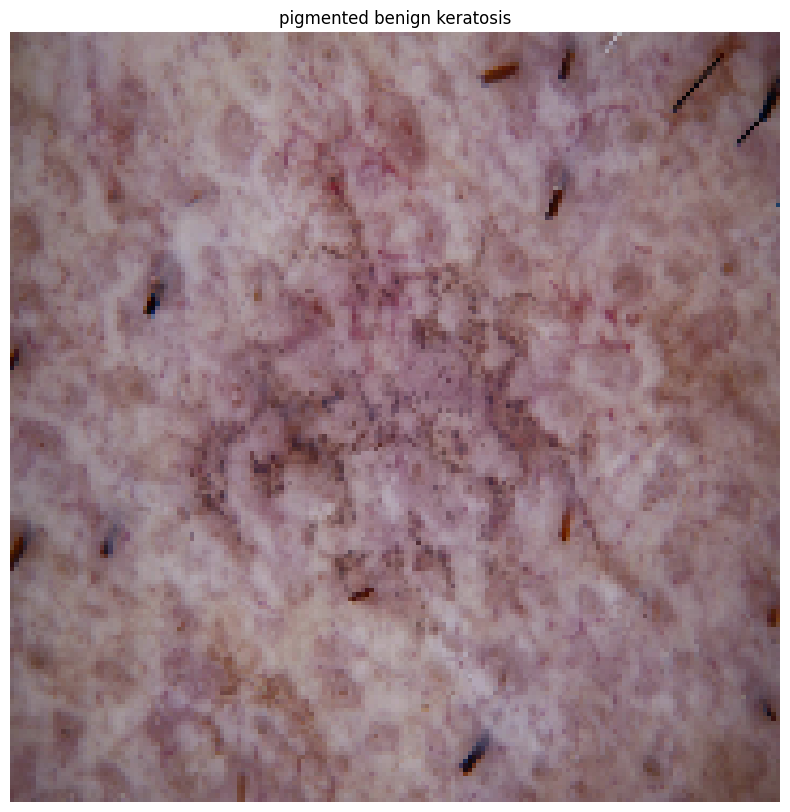

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")

### Dataset visualisation

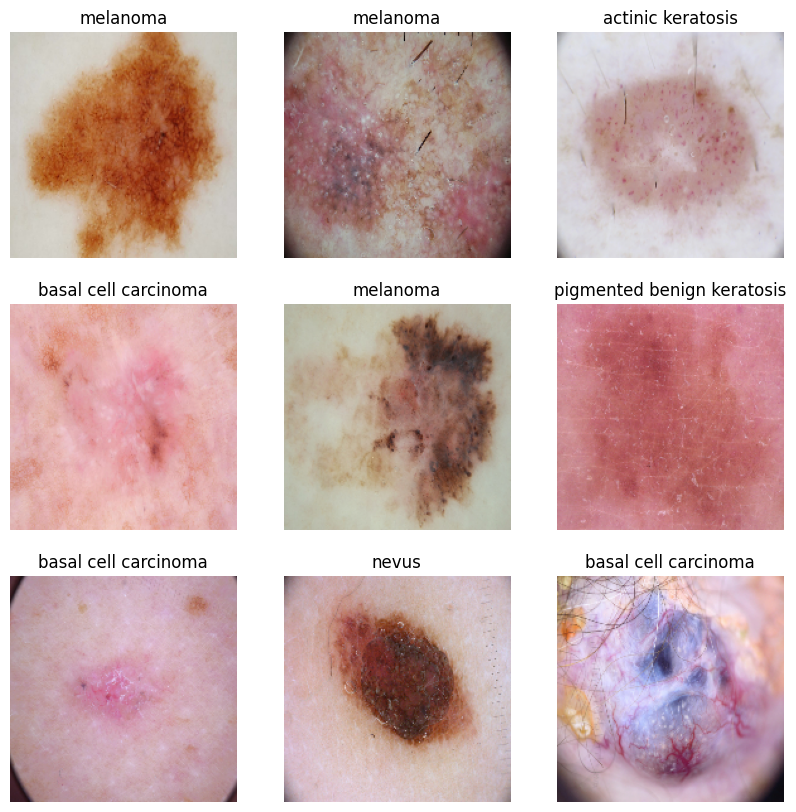

In [11]:
#creating plot for visual verification
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [12]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building & training

In [13]:
#initializing numbers of classes variable
num_classes = 9

#creating sequential processing base model and rescaling images.
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #using max base pooling
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  #using max base pooling
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Flatten(),

  #fully connected layer is a hidden layer in which each node is connected to every node in the subsequent hidden layer.
  layers.Dense(128, activation='relu'),

  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)

])


In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
# choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
#initializing epochs and fitting model
epochs = 20
fitting_result = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 623s 3s/step - loss: 1.9617 - accuracy: 0.2561 - val_loss: 1.8488 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 1.7712 - accuracy: 0.3644 - val_loss: 1.5721 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5584 - accuracy: 0.4498 - val_loss: 1.6394 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4240 - accuracy: 0.5000 - val_loss: 1.5328 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2940 - accuracy: 0.5374 - val_loss: 1.4705 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2078 - accuracy: 0.5698 - val_loss: 1.4927 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0853 - accuracy: 0.6049 - val_loss: 1.6022 - val_accuracy: 0.5145
Epoch 8/20
56

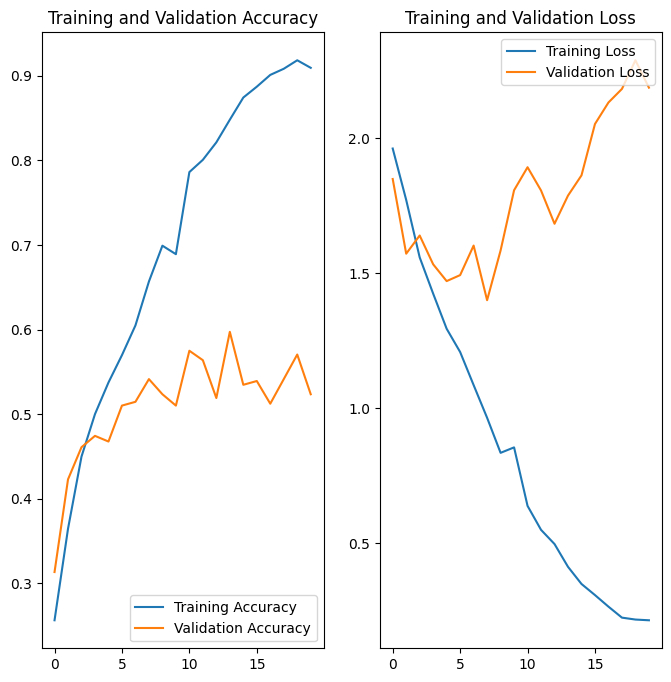

In [17]:
#evaluating model fitting result
acc = fitting_result.history['accuracy']
val_acc = fitting_result.history['val_accuracy']

loss = fitting_result.history['loss']
val_loss = fitting_result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Findings

Above result show that model is failing on validation set. Model is overfitting.

### Implementing data augmentation strategy to resolve underfitting/overfitting

In [18]:
#applying data augumentation strategy
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

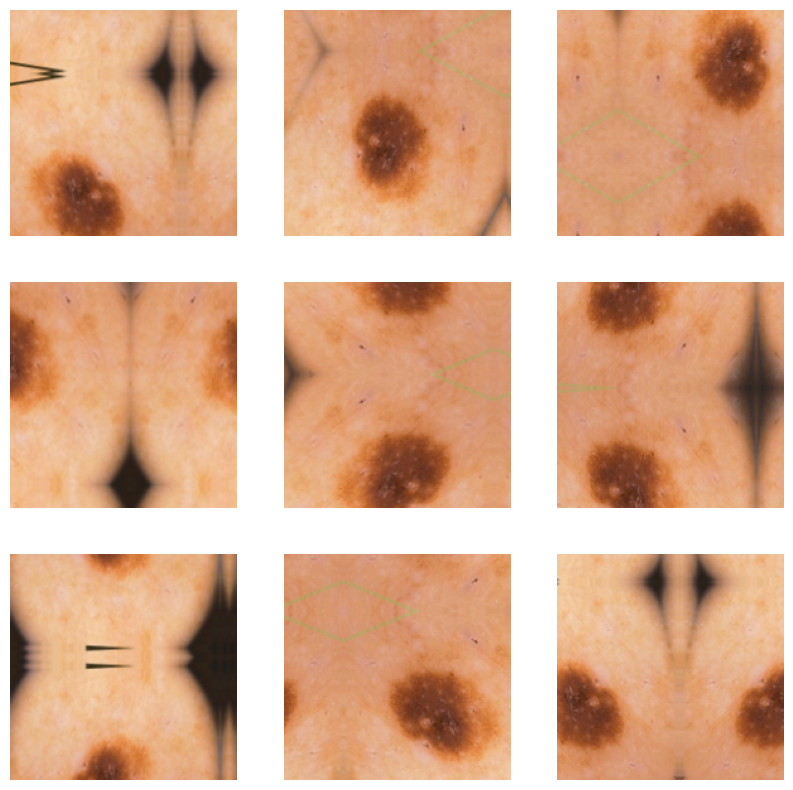

In [19]:
#visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model

In [20]:
#Applying Dropout layer to address overfitting
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [21]:
## configuring compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
epochs = 20
fitting_result = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 141ms/step - loss: 2.1665 - accuracy: 0.2165 - val_loss: 2.2919 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 7s 118ms/step - loss: 1.9630 - accuracy: 0.2617 - val_loss: 1.9708 - val_accuracy: 0.2483
Epoch 3/20
56/56 [==============================] - 7s 116ms/step - loss: 1.8041 - accuracy: 0.3292 - val_loss: 1.7929 - val_accuracy: 0.3468
Epoch 4/20
56/56 [==============================] - 6s 115ms/step - loss: 1.7959 - accuracy: 0.3281 - val_loss: 1.7574 - val_accuracy: 0.3423
Epoch 5/20
56/56 [==============================] - 6s 114ms/step - loss: 1.6995 - accuracy: 0.3560 - val_loss: 1.6459 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 7s 121ms/step - loss: 1.7340 - accuracy: 0.3426 - val_loss: 1.6406 - val_accuracy: 0.3490
Epoch 7/20
56/56 [==============================] - 6s 114ms/step - loss: 1.6632 - accuracy: 0.3750 - val_loss: 1.6228 - val_accuracy: 0.3781
Epoch

### Visualizing the results

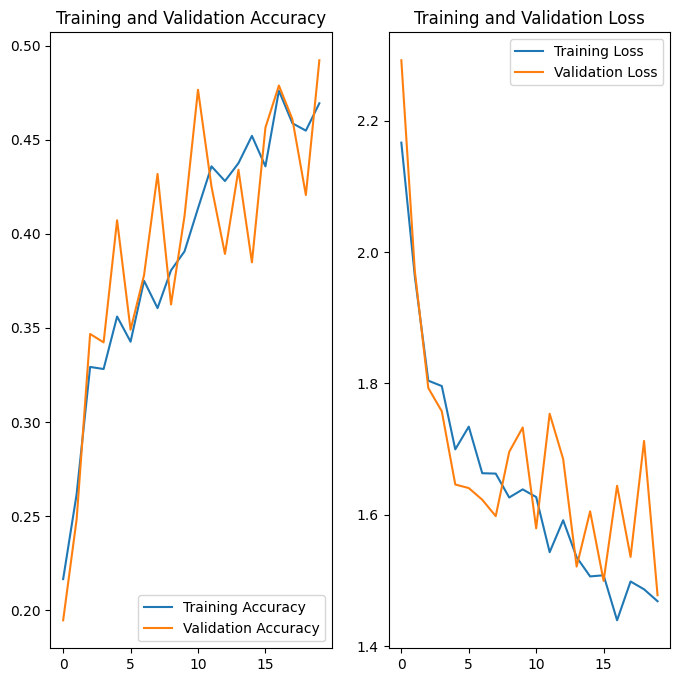

In [23]:
acc = fitting_result.history['accuracy']
val_acc = fitting_result.history['val_accuracy']

loss = fitting_result.history['loss']
val_loss = fitting_result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Findings

Above result show that model is failing on both sets training and validation set. Model is underfitting.

### Checking Class distribution

In [24]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Data/Train/basal cell ...,basal cell carcinoma
1,/content/gdrive/MyDrive/Data/Train/basal cell ...,basal cell carcinoma
2,/content/gdrive/MyDrive/Data/Train/basal cell ...,basal cell carcinoma
3,/content/gdrive/MyDrive/Data/Train/basal cell ...,basal cell carcinoma
4,/content/gdrive/MyDrive/Data/Train/basal cell ...,basal cell carcinoma
...,...,...
2234,/content/gdrive/MyDrive/Data/Train/vascular le...,vascular lesion
2235,/content/gdrive/MyDrive/Data/Train/vascular le...,vascular lesion
2236,/content/gdrive/MyDrive/Data/Train/vascular le...,vascular lesion
2237,/content/gdrive/MyDrive/Data/Train/vascular le...,vascular lesion


Class=1, n=376 (16.793%)
Class=3, n=438 (19.562%)
Class=6, n=77 (3.439%)
Class=5, n=462 (20.634%)
Class=7, n=181 (8.084%)
Class=0, n=114 (5.092%)
Class=2, n=95 (4.243%)
Class=4, n=357 (15.945%)
Class=8, n=139 (6.208%)


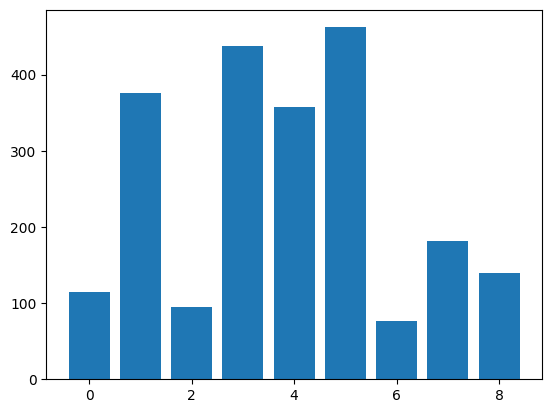

In [26]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### Handling class imbalances

In [27]:
!pip install Augmentor

In [28]:
datapath = r'/content/gdrive/MyDrive/Data/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
p.sample(300)
p.process()

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879BE647790>: 100%|██████████| 300/300 [00:15<00:00, 18.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879BE728BB0>: 100%|██████████| 114/114 [00:07<00:00, 15.09 Samples/s]


In [30]:
path_to_training_dataset="/content/gdrive/MyDrive/Data/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879BFA09450>: 100%|██████████| 500/500 [00:20<00:00, 24.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7879C0FF7DF0>: 100%|██████████| 500/500 [00:19<00:00, 25.33 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879D03DA800>: 100%|██████████| 500/500 [00:19<00:00, 26.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=771x750 at 0x7879C0E371F0>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7879C0E5BDC0>: 100%|██████████| 500/500 [01:19<00:00,  6.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879BE628A30>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7879C0E34C40>: 100%|██████████| 500/500 [00:42<00:00, 11.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879C0E17190>: 100%|██████████| 500/500 [00:17<00:00, 27.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879BFA3EEF0>: 100%|██████████| 500/500 [00:18<00:00, 26.68 Samples/s]


In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4914


### Re-checking distribution of augmented data after adding new images to the original training data.





In [32]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028197.jpg_5212efe7-adf3-4aa7-a0d5-567045b56e21.jpg',
 '/content/gdrive/MyDrive/Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031569.jpg_4d0e91ad-0949-4485-acdb-986238fc842e.jpg',
 '/content/gdrive/MyDrive/Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025266.jpg_3edc384f-def6-4679-aad0-98584164c285.jpg',
 '/content/gdrive/MyDrive/Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031258.jpg_4983d8ea-83d4-4340-82ae-96c22a25db90.jpg',
 '/content/gdrive/MyDrive/Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027814.jpg_2f411004-8d27-4979-afc9-4b3e0d2e6cf0.jpg',
 '/content/gdrive/MyDrive/Data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031026.jpg_7ae8338e-26df-4812-8e3b-4c37a2b8ca18.jpg',
 '/content/gdrive/MyDrive/Data/Train/basal cell carcinoma/output/basal

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [37]:
new_df['Label'].value_counts()

Label
actinic keratosis             1028
pigmented benign keratosis     962
melanoma                       938
basal cell carcinoma           876
nevus                          857
squamous cell carcinoma        681
vascular lesion                639
dermatofibroma                 595
seborrheic keratosis           577
Name: count, dtype: int64

we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Model Building & training on the rectified class imbalance data

In [38]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7153 files belonging to 9 classes.
Using 5723 files for training.


### Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7153 files belonging to 9 classes.
Using 1430 files for validation.


### Create your model

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile your model (Choose optimizer and loss function appropriately)

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
179/179 [==============================] - 49s 77ms/step - loss: 2.0971 - accuracy: 0.2109 - val_loss: 1.7593 - val_accuracy: 0.3671
Epoch 2/20
179/179 [==============================] - 5s 28ms/step - loss: 1.6253 - accuracy: 0.3986 - val_loss: 1.4219 - val_accuracy: 0.4839
Epoch 3/20
179/179 [==============================] - 5s 26ms/step - loss: 1.3066 - accuracy: 0.5151 - val_loss: 1.1960 - val_accuracy: 0.5538
Epoch 4/20
179/179 [==============================] - 5s 27ms/step - loss: 1.0905 - accuracy: 0.6002 - val_loss: 1.0063 - val_accuracy: 0.6133
Epoch 5/20
179/179 [==============================] - 5s 27ms/step - loss: 0.9175 - accuracy: 0.6659 - val_loss: 0.9039 - val_accuracy: 0.6671
Epoch 6/20
179/179 [==============================] - 5s 26ms/step - loss: 0.7847 - accuracy: 0.7168 - val_loss: 0.8742 - val_accuracy: 0.6895
Epoch 7/20
179/179 [==============================] - 5s 27ms/step - loss: 0.6201 - accuracy: 0.7758 - val_loss: 0.8595 - val_accuracy: 0.723

###   Visualize the model results

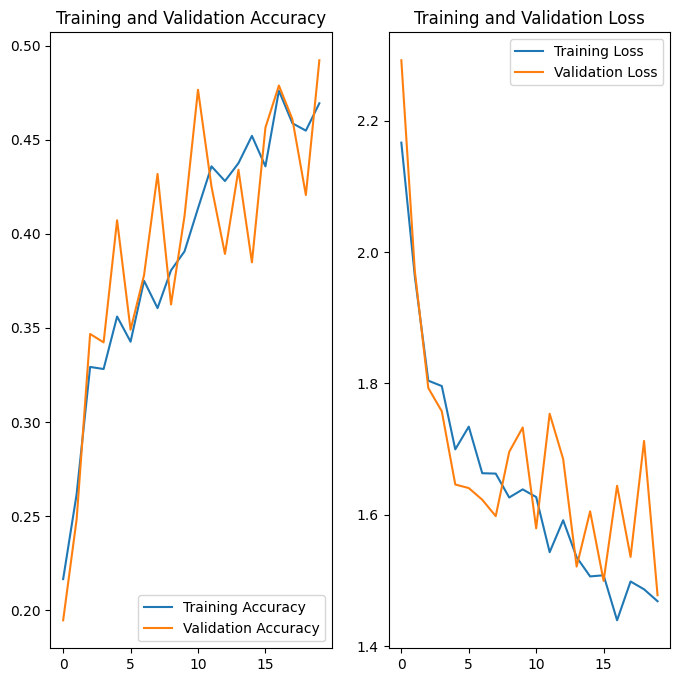

In [44]:
acc = fitting_result.history['accuracy']
val_acc = fitting_result.history['val_accuracy']

loss = fitting_result.history['loss']
val_loss = fitting_result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Findings

As per latest statistics, Model has formed well on both set training and validation set. It seems that model is almost free from overfitting and underfitting issues. Class rebalance solution is effective for this case.